In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KERAS_TUNER_BACKEND'] = 'tensorflow'


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def split_dir_to_train_test_val(directory="/content/drive/MyDrive/skin_disease_augmented/",
                                train_size=0.7,
                                test_size=0.2,
                                val_size=0.1):



    rng = random.Random(42)

    for root, folders, files in os.walk(directory):
        for folder in folders:
            list_of_files = []
            for file_name in os.listdir(os.path.join(root, folder)):
                list_of_files.append(file_name)

            rng.shuffle(list_of_files)

            train_files = list_of_files[:int(len(list_of_files)*train_size)]
            test_files = list_of_files[int(len(list_of_files)*train_size):int(len(list_of_files)*(train_size+test_size))]
            val_files = list_of_files[int(len(list_of_files)*(train_size+test_size)):]

            for one_file in train_files:
                dest_dir = "files/train/" + folder + "/"
                shutil.copy2(src=os.path.join(root, folder, one_file),
                             dst=os.path.join(dest_dir, one_file))

            for one_file in test_files:
                dest_dir = "files/test/" + folder + "/"
                shutil.copy2(src=os.path.join(root, folder, one_file),
                             dst=os.path.join(dest_dir, one_file))

            for one_file in val_files:
                dest_dir = "files/validation/" + folder + "/"
                shutil.copy2(src=os.path.join(root, folder, one_file),
                             dst=os.path.join(dest_dir, one_file))


def get_class_names(directory):

    data_dir = pathlib.Path(directory)
    class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
    return class_names

split_dir_to_train_test_val(directory="/content/drive/MyDrive/skin_disease_augmented/",
                            train_size=0.7,
                            test_size=0.2,
                            val_size=0.1)

train_datagen = ImageDataGenerator(rescale=1/255., rotation_range=45, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=(0.5, 1.5), shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory="files/train/",
                                               target_size=(240, 240),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(directory="files/test/",
                                             target_size=(240, 240),
                                             batch_size=32,
                                             class_mode="categorical")

validation_data = val_datagen.flow_from_directory(directory="files/validation/",
                                                  target_size=(240, 240),
                                                  batch_size=32,
                                                  class_mode="categorical")

def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'),
        Dropout(0.5),
        Dense(len(train_data.class_indices), activation='softmax')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='random_search',
    project_name='VGG16_multiclass_classification')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(train_data,
             validation_data=validation_data,
             epochs=10,
             batch_size=32,
             callbacks=[early_stopping])

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters}")

best_model = tuner.hypermodel.build(best_hyperparameters)

history = best_model.fit(train_data,
                         validation_data=validation_data,
                         epochs=100,
                         batch_size=32)

Trial 5 Complete [00h 16m 10s]
val_accuracy: 0.3507108986377716

Best val_accuracy So Far: 0.47867298126220703
Total elapsed time: 01h 17m 01s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f01e01aa800>
Epoch 1/100
138/138 [==============================] - 87s 620ms/step - loss: 1.5324 - accuracy: 0.3123 - val_loss: 1.4290 - val_accuracy: 0.4076
Epoch 2/100
138/138 [==============================] - 86s 620ms/step - loss: 1.4311 - accuracy: 0.3792 - val_loss: 1.3838 - val_accuracy: 0.4234
Epoch 3/100
138/138 [==============================] - 87s 628ms/step - loss: 1.3935 - accuracy: 0.3900 - val_loss: 1.3471 - val_accuracy: 0.4329
Epoch 4/100
138/138 [==============================] - 83s 605ms/step - loss: 1.3772 - accuracy: 0.4048 - val_loss: 1.3454 - val_accuracy: 0.4234
Epoch 5/100
138/138 [==============================] - 84s 606ms/step - loss: 1.3542 - accuracy: 0.4177 - val_loss: 1.3395 - val_accuracy: 0.4218
Epoch 6

In [ ]:
best_model.evaluate(test_data)

40/40 [==============================] - 6s 136ms/step - loss: 1.0337 - accuracy: 0.5922


[1.0337249040603638, 0.5922406911849976]

<Axes: >

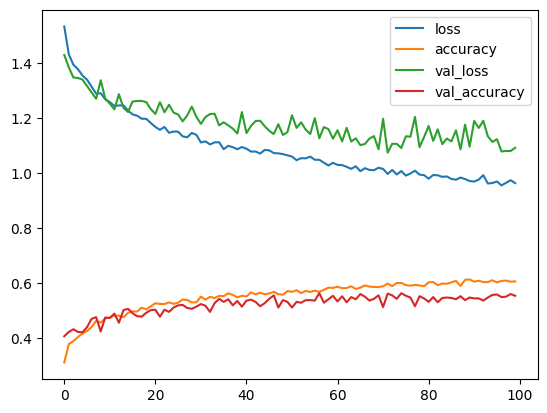

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
predictions = best_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_data.classes

# Calculate evaluation metrics
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')
mcc = matthews_corrcoef(true_labels, predicted_classes)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(cm)):
    tn = np.sum(np.delete(cm, i, 0)[:, np.delete(np.arange(len(cm)), i)])
    fp = np.sum(cm[i, np.delete(np.arange(len(cm)), i)])
    specificity_per_class.append(tn / (tn + fp))

# Calculate average specificity
specificity = np.mean(specificity_per_class)

# Print evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)
print("Specificity:", specificity)


40/40 [==============================] - 8s 192ms/step
Precision: 0.17866030681640155
Recall: 0.19081551860649248
F1 Score: 0.1778346248595219
Matthews Correlation Coefficient: -0.023346543934096884
Specificity: 0.7953289778816037


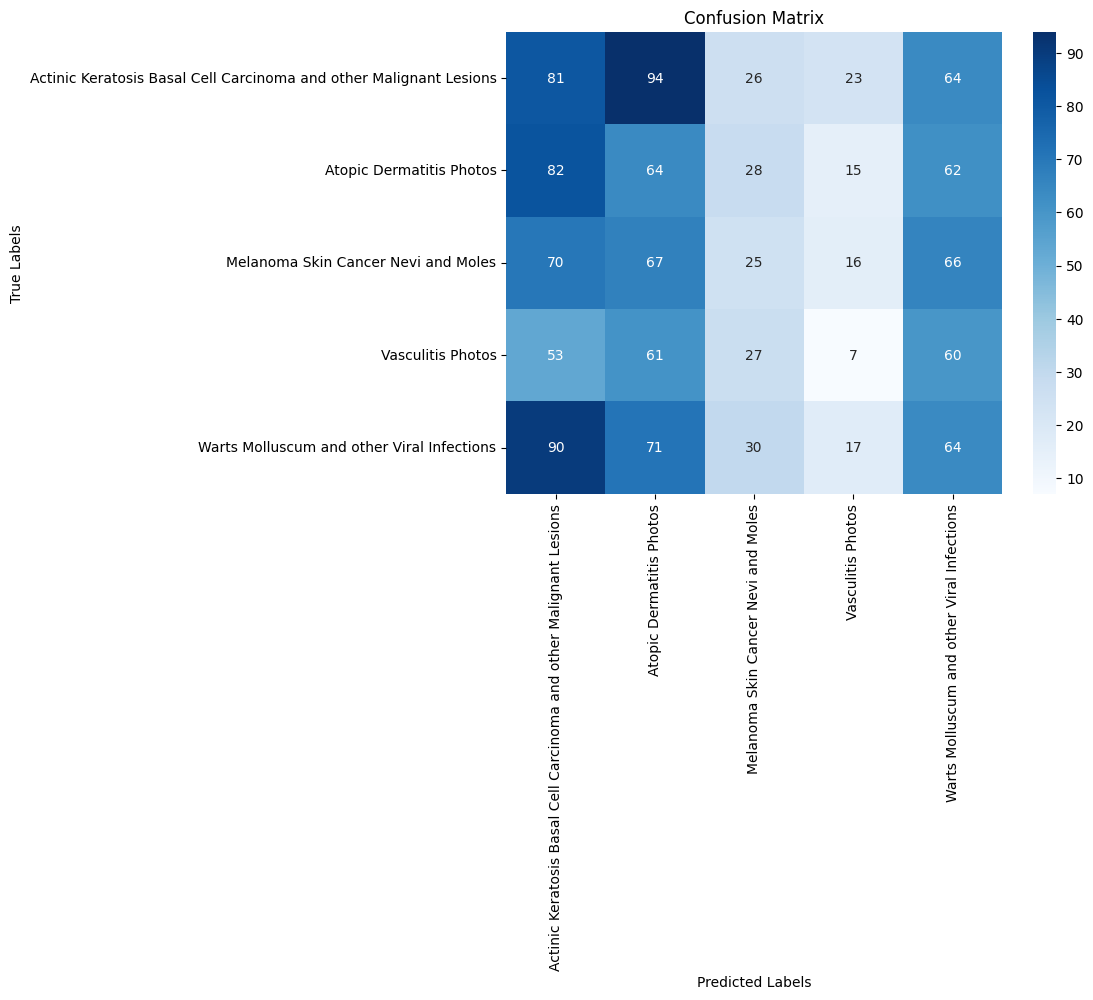

In [ ]:
class_labels = test_data.class_indices.keys()

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
